## Работа с моделью - Создание каркаса

In [1]:
from popframe.method.popuation_frame import PopFrame
from popframe.models.region import Region

In [26]:
# # Создание экземпляра GraphMethod с данными
# region_model = Region.from_pickle('/home/mvin/PopFrame/PopFrame/examples/data/Ленинградская область.pickle')
region_model = Region.from_pickle('/home/mvin/PopFrame/PopFrame/examples/data/Тюменская область.pickle')
frame_method = PopFrame(region=region_model)

# Получение графа
G = frame_method.build_network_frame()


In [27]:
num_edges = G.number_of_edges()
print("Количество рёбер в графе:", num_edges)


Количество рёбер в графе: 1236


In [28]:
G.nodes(data=True)

NodeDataView({0: {'pos': (70.158302, 55.208782), 'level': 'Малое сельское поселение', 'name': 'Красивое'}, 1: {'pos': (69.9498325, 55.2699663), 'level': 'Среднее сельское поселение', 'name': 'Александровка'}, 2: {'pos': (70.08474, 55.261311), 'level': 'Малое сельское поселение', 'name': 'Михайловка'}, 3: {'pos': (70.098688, 55.4339034), 'level': 'Среднее сельское поселение', 'name': 'Покровка'}, 4: {'pos': (70.156395, 55.349472), 'level': 'Малое сельское поселение', 'name': 'Таволжан'}, 5: {'pos': (70.193169, 55.477257), 'level': 'Малое сельское поселение', 'name': 'Кочкарное'}, 6: {'pos': (69.8259537, 55.4657253), 'level': 'Малое сельское поселение', 'name': 'Пелевино'}, 7: {'pos': (69.9129114, 55.4500633), 'level': 'Среднее сельское поселение', 'name': 'Усово'}, 8: {'pos': (69.9173793, 55.5628115), 'level': 'Малое сельское поселение', 'name': 'Большой Куртал'}, 9: {'pos': (70.07074, 55.555637), 'level': 'Малое сельское поселение', 'name': 'Задонка'}, 10: {'pos': (70.143921, 55.926128

In [29]:
G.edges(data=True)

EdgeDataView([(0, 1, {'level': 'Малое сельское поселение'}), (1, 2, {'level': 'Малое сельское поселение'}), (1, 239, {'level': 'Среднее сельское поселение'}), (3, 4, {'level': 'Малое сельское поселение'}), (3, 5, {'level': 'Малое сельское поселение'}), (3, 239, {'level': 'Среднее сельское поселение'}), (6, 7, {'level': 'Малое сельское поселение'}), (7, 239, {'level': 'Среднее сельское поселение'}), (8, 22, {'level': 'Малое сельское поселение'}), (9, 13, {'level': 'Малое сельское поселение'}), (10, 14, {'level': 'Малое сельское поселение'}), (10, 19, {'level': 'Малое сельское поселение'}), (10, 20, {'level': 'Малое сельское поселение'}), (10, 11, {'level': 'Среднее сельское поселение'}), (10, 22, {'level': 'Среднее сельское поселение'}), (10, 200, {'level': 'Среднее сельское поселение'}), (10, 212, {'level': 'Среднее сельское поселение'}), (10, 226, {'level': 'Среднее сельское поселение'}), (10, 38, {'level': 'Большое сельское поселение'}), (11, 33, {'level': 'Малое сельское поселение'}

Number of agglomerations: 32


/tmp/ipykernel_960/3900026983.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
/home/mvin/PopFrame/PopFrame/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


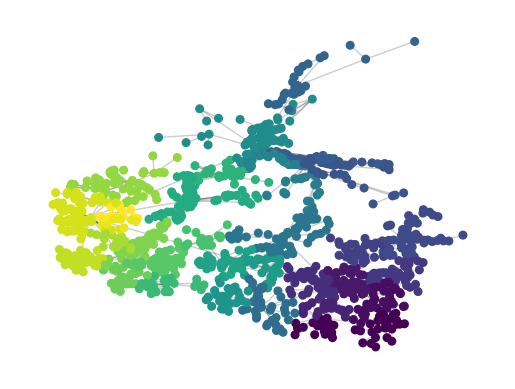

In [67]:
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def detect_agglomerations(G):
    """
    Detects agglomerations in the given graph using the Louvain algorithm.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.

    Returns:
    dict: A dictionary where keys are node indices and values are agglomeration ids.
    """
    # Apply the Louvain algorithm to detect communities
    partition = community_louvain.best_partition(G)

    return partition

def get_largest_city_name(towns_gdf, nodes):
    """
    Finds the largest city name in the given set of nodes.

    Parameters:
    towns_gdf (GeoDataFrame): The GeoDataFrame containing town information.
    nodes (list): The list of nodes in the agglomeration.

    Returns:
    str: The name of the largest city.
    """
    largest_city = towns_gdf.loc[nodes].sort_values(by='population', ascending=False).iloc[0]
    return largest_city['name']

def build_agglomeration_polygons(G, towns_gdf, partition):
    """
    Builds polygons for each agglomeration and assigns the name of the largest city.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.
    towns_gdf (GeoDataFrame): The GeoDataFrame containing town information.
    partition (dict): A dictionary where keys are node indices and values are agglomeration ids.

    Returns:
    GeoDataFrame: A GeoDataFrame with agglomeration polygons and names.
    """
    agglomerations = {}
    for node, agglomeration_id in partition.items():
        if agglomeration_id not in agglomerations:
            agglomerations[agglomeration_id] = []
        agglomerations[agglomeration_id].append(node)
    
    polygons = []
    names = []
    
    for agglomeration_id, nodes in agglomerations.items():
        points = towns_gdf.loc[nodes].geometry
        polygon = Polygon(points.unary_union.convex_hull)
        name = get_largest_city_name(towns_gdf, nodes)
        polygons.append(polygon)
        names.append(name)
    
    agglomeration_gdf = gpd.GeoDataFrame({'name': names, 'geometry': polygons}, crs=towns_gdf.crs)
    
    return agglomeration_gdf

def visualize_agglomerations(G, partition):
    """
    Visualizes agglomerations on the given graph.

    Parameters:
    G (networkx.Graph): The input graph with nodes and edges.
    partition (dict): A dictionary where keys are node indices and values are agglomeration ids.
    """
    pos = nx.get_node_attributes(G, 'pos')
    cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.axis('off')
    plt.show()

# Пример использования:
# Предполагая, что у вас есть граф G и towns_gdf с информацией о городах
# G = build_network_frame()  # Пример графа
# towns_gdf = ...  # GeoDataFrame с информацией о городах, включая уровень и имя
resolution_value = 1  # Попробуйте разные значения, чтобы увидеть эффект
agglomerations = detect_agglomerations(G)
num_agglomerations = len(set(agglomerations.values()))
print(f"Number of agglomerations: {num_agglomerations}")

# Визуализируем агломерации
visualize_agglomerations(G, agglomerations)

towns_gdf = region_model.get_towns_gdf()
# Создаем полигоны агломераций и получаем GeoDataFrame
agglomeration_gdf = build_agglomeration_polygons(G, towns_gdf, agglomerations)



In [68]:
agglomeration_gdf.explore()